In [2]:
import torch
import pickle
from stable_baselines3 import DQN, PPO
# from sb3_contrib import QRDQN
from env import create_env
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
with open('first_try.pkl', 'rb') as file:
    replay_buffer = pickle.load(file)

observations_for_action = replay_buffer.observations.squeeze(axis=1)[:100000]
real_actions = replay_buffer.actions.squeeze(axis=1)[:100000]
# real_actions = real_actions[(real_actions != 0)]
# indices = np.where(real_actions)
# observations_for_action = observations[indices]

env = create_env(use_lppos=False, world_name="21_05",use_predator=True, max_steps=300, time_step=0.25, reward_structure={"puffed":-100, "finished":10})
print(observations_for_action.shape)
# model_DQN = DQN.load("DQN_control_compare.zip", env = env) 
# model_PPO = PPO.load("PPO_control.zip", env = env) 
# model_QRDQN = QRDQN.load("QRDQN_control.zip", env = env)
# policy_DQN = model_DQN.policy 
# policy_PPO = model_PPO.policy 
# # policy_QRDQN = model_QRDQN.policy
# trained_actions_DQN, _= model_DQN.predict(observations_for_action) 
# trained_actions_PPO, _= model_PPO.predict(observations_for_action)
# trained_actions_QRDQN, _= model_QRDQN.predict(observations_for_action)



(100000, 11)


In [4]:
# Load trained models
import torch
import torch.nn as nn
import gymnasium as gym
from torch.distributions import Categorical
import argparse
import cellworld_gym as cwg

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(11, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 295)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def get_action(self, x, deterministic=False):
        logits = self.forward(x)
        if deterministic:
            return torch.argmax(logits, dim=1).detach().cpu()
        else:
        # get action based on the logit with categorical distribution
            dist = Categorical(logits=logits)
            action = dist.sample()
        return action.detach().cpu()
    
model = Network()
model.load_state_dict(torch.load('mouse_policy_top3.pth', map_location=torch.device('cpu')))
with torch.no_grad():  # No need to compute gradients during inference
    observations_for_action_tensor = torch.tensor(observations_for_action, dtype=torch.float32)
    predicted_action = model.get_action(observations_for_action_tensor, deterministic=False)
predicted_action

tensor([  4,   2,   4,  ..., 235, 235, 235])

In [5]:
import numpy as np
# Example action array
actions = predicted_action.numpy()
# Count the frequency of each unique action
unique_actions, action_counts = np.unique(actions, return_counts=True)
# Calculate the total number of actions
total_actions = len(actions)
# Calculate the probability of each action
action_probabilities = action_counts / total_actions
# Print action indices and their probabilities
for action, probability in zip(unique_actions, action_probabilities):
    print(f"Action: {action}, Probability: {probability}")

Action: 0, Probability: 0.12549
Action: 1, Probability: 0.04219
Action: 2, Probability: 0.06338
Action: 3, Probability: 0.0029
Action: 4, Probability: 0.0311
Action: 5, Probability: 0.01174
Action: 6, Probability: 0.01572
Action: 7, Probability: 0.00326
Action: 8, Probability: 0.01898
Action: 9, Probability: 0.00268
Action: 10, Probability: 0.0091
Action: 11, Probability: 0.00239
Action: 12, Probability: 0.00352
Action: 13, Probability: 0.01987
Action: 14, Probability: 0.00328
Action: 15, Probability: 0.00135
Action: 16, Probability: 0.00561
Action: 17, Probability: 0.00133
Action: 18, Probability: 0.02262
Action: 19, Probability: 0.00406
Action: 20, Probability: 0.0011
Action: 21, Probability: 0.00088
Action: 22, Probability: 0.00271
Action: 23, Probability: 0.00096
Action: 24, Probability: 0.02126
Action: 25, Probability: 0.00635
Action: 26, Probability: 0.00232
Action: 27, Probability: 0.00081
Action: 28, Probability: 0.00432
Action: 29, Probability: 0.00142
Action: 30, Probability:

In [6]:
import numpy as np
# Example action array
real_actions = real_actions
# Count the frequency of each unique action
unique_actions, action_counts = np.unique(real_actions, return_counts=True)
# Calculate the total number of actions
total_actions = len(real_actions)
# Calculate the probability of each action
action_probabilities_real = action_counts / total_actions

len(action_probabilities_real)

295

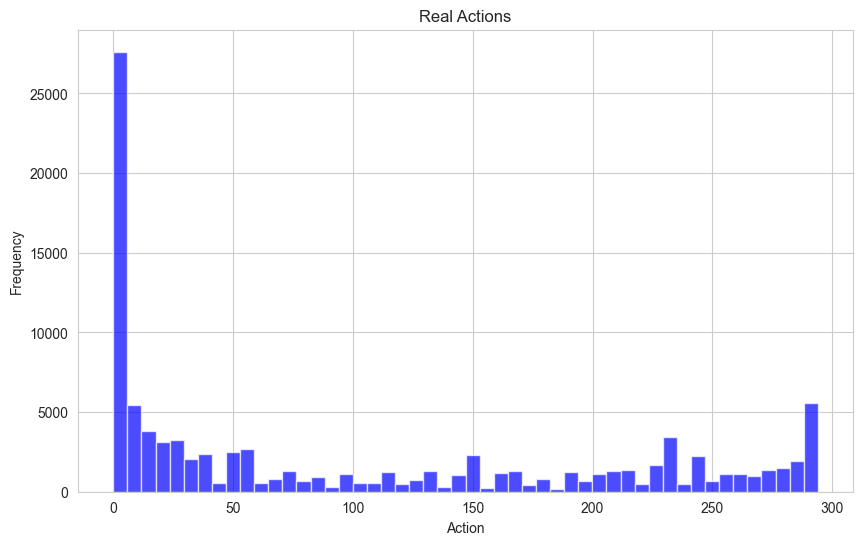

In [20]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(real_actions, bins=50, color='blue', alpha=0.7)
plt.title('Real Actions')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

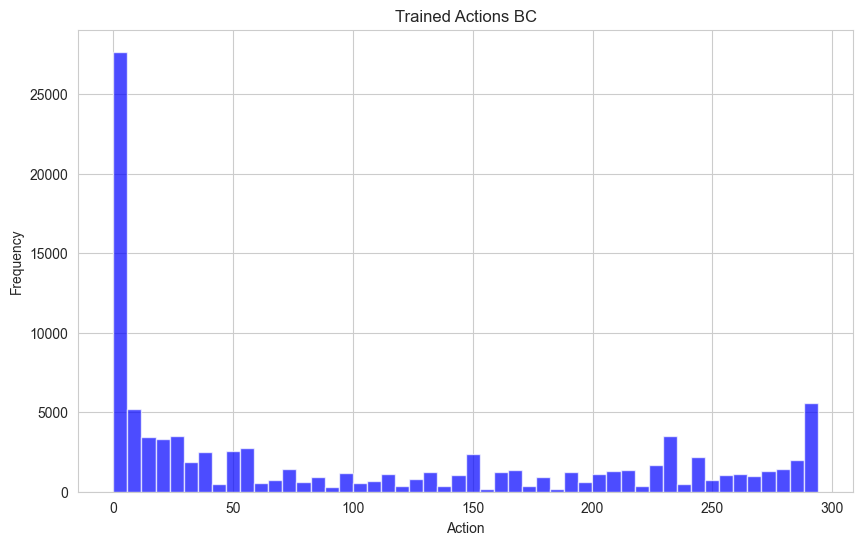

In [21]:
# Plot histograms of trained actions for DQN
plt.figure(figsize=(10, 6))
plt.hist(predicted_action, bins=50, color='blue', alpha=0.7)
plt.title('Trained Actions BC')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
from scipy.stats import entropy
action_probabilities_real = np.exp(action_probabilities_real) / np.sum(np.exp(action_probabilities_real))
action_probabilities = np.exp(action_probabilities) / np.sum(np.exp(action_probabilities))
kl_divergence_BC = entropy(action_probabilities_real, action_probabilities)
print("KL Divergence:", kl_divergence_BC)

KL Divergence: 1.4248751999871712e-07


7.569894318469576e-07 is IQL

In [6]:
real_probs = np.exp(real_actions) / np.sum(np.exp(real_actions))
len(real_probs)

100000

In [15]:
print(real_probs)
print(trained_probs_DQN)
print(trained_probs_PPO)
print(trained_probs_QRDQN)

[6.07357566e-131 4.48779913e-130 3.63650130e-126 ... 9.42016976e-030
 9.42016976e-030 9.42016976e-030]
[3.64830591e-15 1.83676710e-59 3.32682436e-18 ... 7.32781831e-14
 7.32781831e-14 7.32781831e-14]
[1.26190859e-90 1.26190859e-90 1.26190859e-90 ... 1.26190859e-90
 1.26190859e-90 1.26190859e-90]
[4.29849309e-05 4.29849309e-05 4.29849309e-05 ... 4.29849309e-05
 5.28605361e-85 5.28605361e-85]


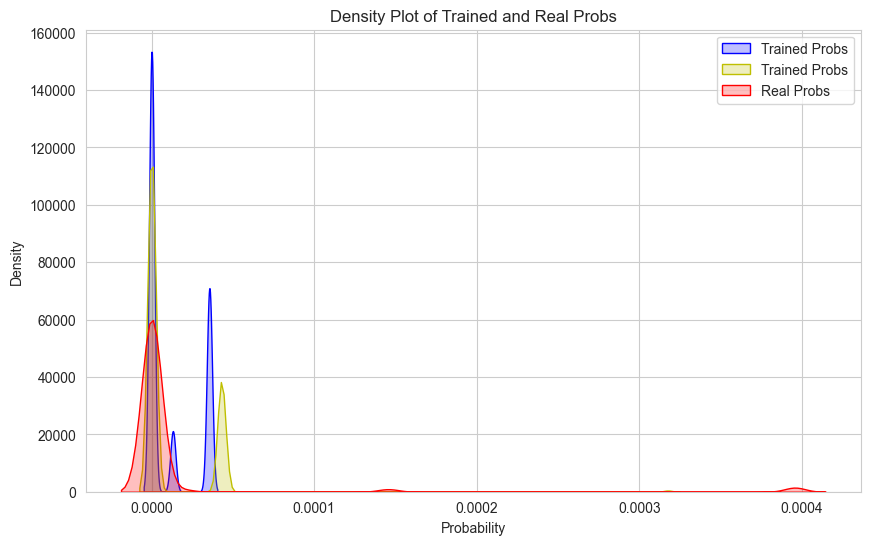

In [18]:
plt.figure(figsize=(10, 6))
sns.kdeplot(trained_probs_DQN, fill=True, color="b", label="Trained Probs")
sns.kdeplot(trained_probs_QRDQN, fill=True, color="y", label="Trained Probs")
sns.kdeplot(real_probs, fill=True, color="r", label="Real Probs")
plt.title("Density Plot of Trained and Real Probs")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

In [10]:
real_actions_norm = (real_actions - np.min(real_actions)) / (np.max(real_actions) - np.min(real_actions))
# trained_actions_DQN_norm = (trained_actions_DQN - np.min(trained_actions_DQN)) / (np.max(trained_actions_DQN) - np.min(trained_actions_DQN))
# trained_actions_PPO_norm = (trained_actions_PPO - np.min(trained_actions_PPO)) / (np.max(trained_actions_PPO) - np.min(trained_actions_PPO))
# trained_action_TRPPO_norm = (trained_actions_QRDQN - np.min(trained_actions_QRDQN)) / (np.max(trained_actions_QRDQN) - np.min(trained_actions_QRDQN))

# Calculate KL divergence with normalized values
real_probs_norm = np.exp(real_actions_norm) / np.sum(np.exp(real_actions_norm))
trained_probs_DQN_norm = np.exp(trained_actions_DQN_norm) / np.sum(np.exp(trained_actions_DQN_norm))
trained_probs_PPO_norm = np.exp(trained_actions_PPO_norm) / np.sum(np.exp(trained_actions_PPO_norm))
trained_probs_TRPPO_norm = np.exp(trained_action_TRPPO_norm) / np.sum(np.exp(trained_action_TRPPO_norm))

kl_divergence_DQN_norm = entropy(real_probs_norm, trained_probs_DQN_norm)
kl_divergence_PPO_norm = entropy(real_probs_norm, trained_probs_PPO_norm)
kl_divergence_TRPPO_norm = entropy(real_probs_norm, trained_probs_TRPPO_norm)

print("KL Divergence DQN (Normalized):", kl_divergence_DQN_norm)
print("KL Divergence PPO (Normalized):", kl_divergence_PPO_norm)
print("KL Divergence QRPPO (Normalized):", kl_divergence_QRPPO_norm)

NameError: name 'trained_actions_DQN_norm' is not defined

In [ ]:
# Generate random actions
random_actions = np.random.rand(len(real_actions))

# Calculate KL divergence with random actions
random_probs = np.exp(random_actions) / np.sum(np.exp(random_actions))
kl_divergence_random = entropy(real_probs, random_probs)

print("KL Divergence DQN:", kl_divergence_DQN_norm)
print("KL Divergence PPO:", kl_divergence_PPO_norm)
print("KL Divergence Random:", kl_divergence_random)

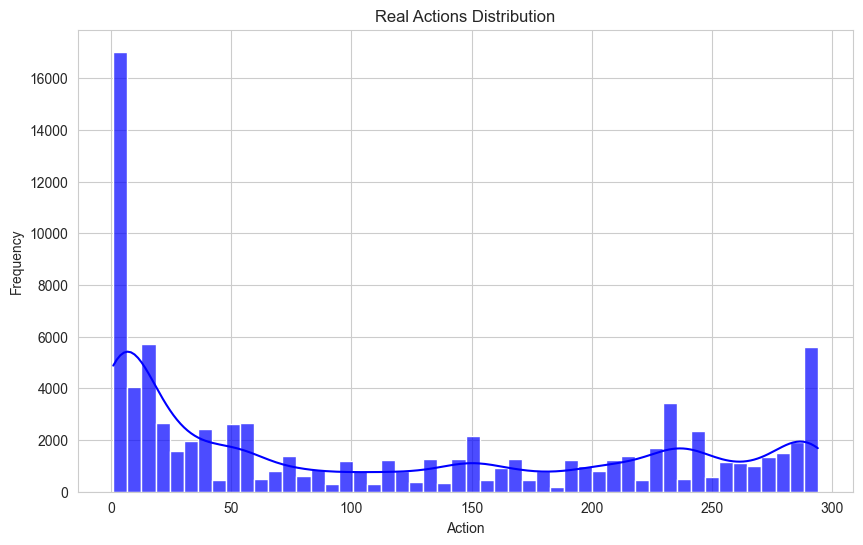

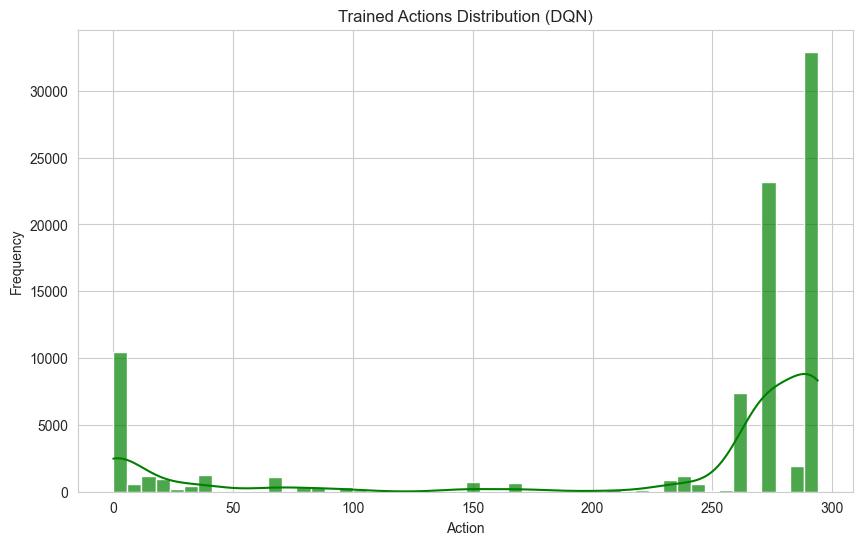

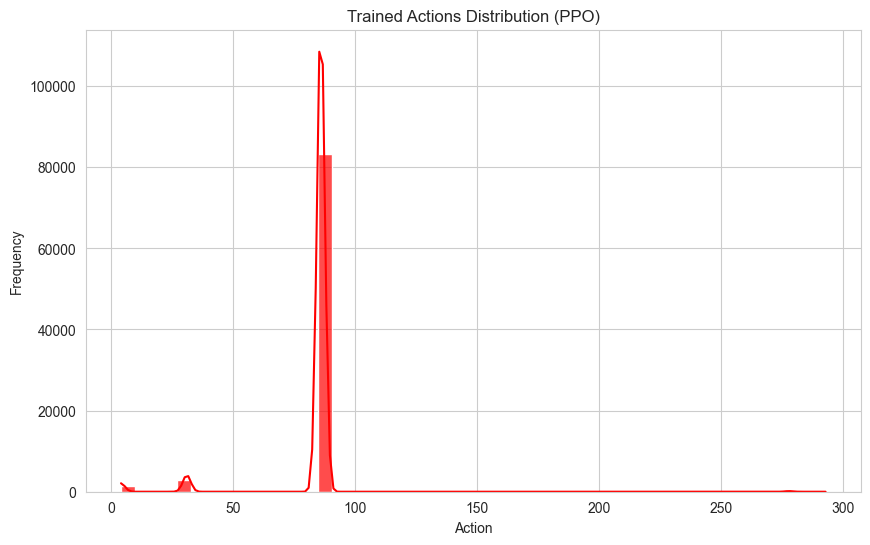

In [19]:
# Plot real actions distribution
plt.figure(figsize=(10, 6))
sns.histplot(real_actions, bins=50, kde=True, color='blue', alpha=0.7)
plt.title('Real Actions Distribution')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot trained actions distribution (DQN)
plt.figure(figsize=(10, 6))
sns.histplot(trained_actions_DQN, bins=50, kde=True, color='green', alpha=0.7)
plt.title('Trained Actions Distribution (DQN)')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot trained actions distribution (PPO)
plt.figure(figsize=(10, 6))
sns.histplot(trained_actions_PPO, bins=50, kde=True, color='red', alpha=0.7)
plt.title('Trained Actions Distribution (PPO)')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()